# Colab 기준 경로로 작성

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. 자율주행 보조장치
## 2-1. KITTI 데이터셋
- 자율주행 보조장치 object detection 요구사항

  - 사람이 카메라에 감지되면 정지
  - 차량이 일정 크기 이상으로 감지되면 정지


- [KITTI 데이터셋](https://www.cvlibs.net/datasets/kitti/)

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset

import os, copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import glob

In [99]:
save_dir = "/content/drive/MyDrive/Data/GoingDeeperQ5/KITTY"
os.makedirs(save_dir, exist_ok=True)

In [1]:
# !wget -P {save_dir} https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
# !wget -P {save_dir} https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
# !unzip {save_dir}/data_object_image_2.zip -d {save_dir}
# !unzip {save_dir}/data_object_label_2.zip -d {save_dir}

## 2-2. 데이터 살펴보기

### KITTI 데이터셋 Object Label 정보

| Values | Name        | Description |
|--------|------------|-------------|
| 1      | type       | Describes the type of object: 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare' |
| 1      | truncated  | Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries |
| 1      | occluded   | Integer (0,1,2,3) indicating occlusion state:<br>0 = fully visible, 1 = partly occluded, 2 = largely occluded, 3 = unknown |
| 1      | alpha      | Observation angle of object, ranging [-π .. π] |
| 4      | bbox       | 2D bounding box of object in the image (0-based index): contains left, top, right, bottom pixel coordinates |
| 3      | dimensions | 3D object dimensions: height, width, length (in meters) |
| 3      | location   | 3D object location x, y, z in camera coordinates (in meters) |
| 1      | rotation_y | Rotation ry around Y-axis in camera coordinates [-π .. π] |
| 1      | score      | Only for results: Float, indicating confidence in detection, needed for p/r curves, higher is better |


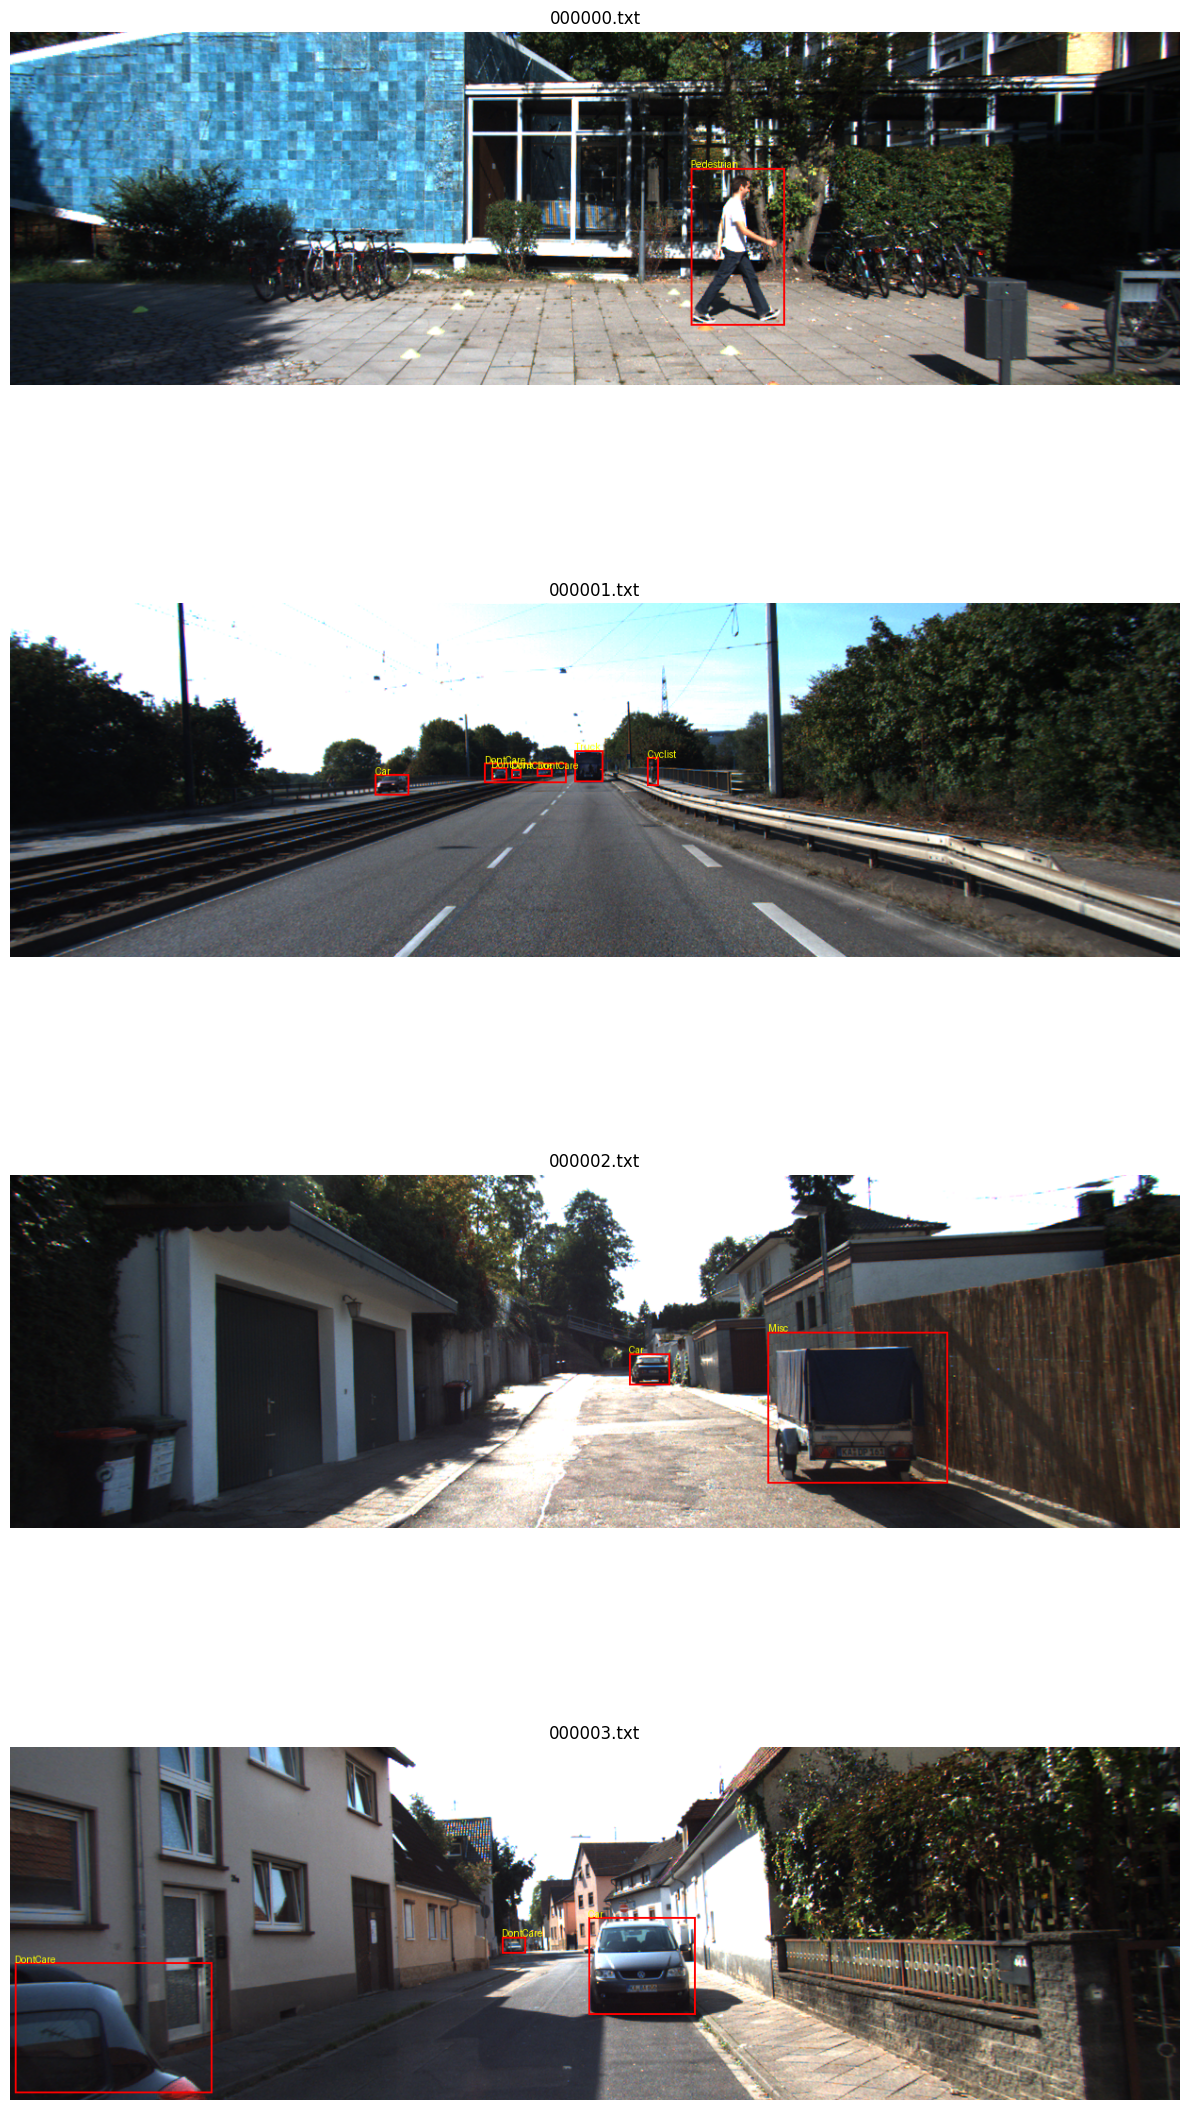

In [10]:
img_dir = "/content/drive/MyDrive/Data/GoingDeeperQ5/KITTY/training/training/image_2"
label_dir = "/content/drive/MyDrive/Data/GoingDeeperQ5/KITTY/training/training/label_2"

img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))


num_images = 4
img_files = img_files[:num_images]


fig, axes = plt.subplots(num_images, 1, figsize=(12, 6*num_images))

for i, img_path in enumerate(img_files):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    base_name = os.path.basename(img_path).replace(".png", ".txt")
    label_path = os.path.join(label_dir, base_name)

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                items = line.strip().split()
                cls = items[0]
                # bbox 좌표: left, top, right, bottom
                bbox = list(map(float, items[4:8]))
                draw.rectangle(bbox, outline="red", width=2)
                draw.text((bbox[0], bbox[1]-10), cls, fill="yellow")

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(base_name)

plt.tight_layout()
plt.show()


# 3. RetinaNet
- [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)
- RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용

## 3-1. Focal Loss
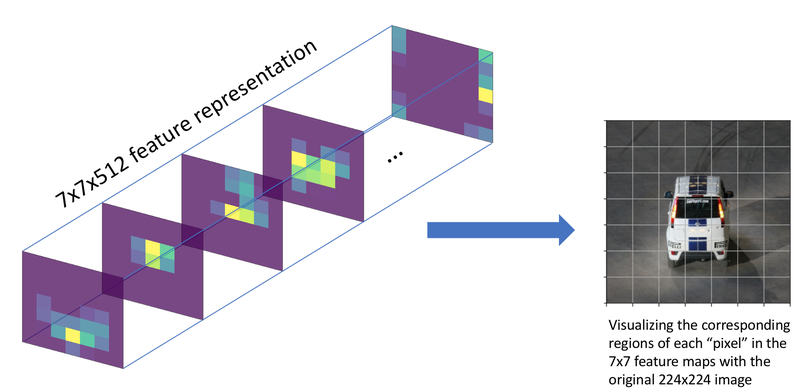

**Focal Loss 도입 배경과 목적**

1. 1-stage detection 문제
    - YOLO, SSD 같은 1-stage 모델은 이미지의 모든 **grid** 를 한 번에 학습함.
    - 대부분의 그리드는 **background** 이고 일부만 **foreground** 를 포함.
    - 이로 인해 **class imbalance** 문제가 발생함.

2. 그리드 vs 픽셀 혼동 주의
    - **Feature level**: 7x7 feature map에서 한 위치가 하나의 **pixel**  
    - **Image level**: 실제 이미지에서 각 grid는 해당 pixel의 **receptive field**를 나타냄

3. Focal Loss의 역할
    - background에 대한 loss 비중을 줄이고, **어려운(focal) 샘플**에 집중
    - class imbalance 문제를 완화하여 **정확도 향상**

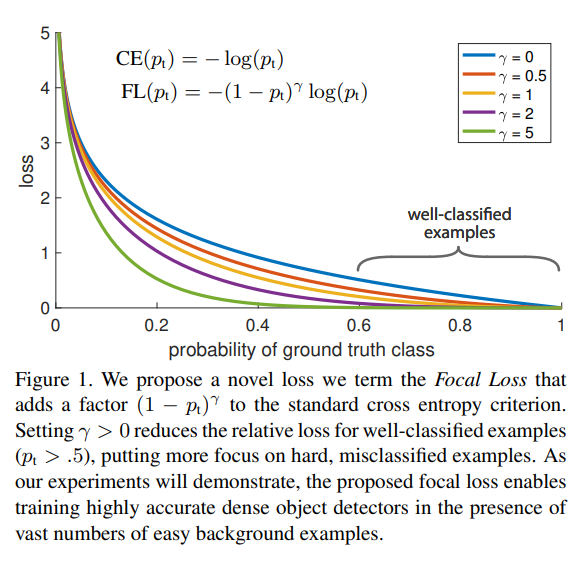

**Focal Loss와 CE 기반**

- Focal loss는 기존의 **교차 엔트로피(cross-entropy, CE)** 를 기반으로 만들어짐.
- Focal loss는 교차 엔트로피 $CE(p_t)$ 에 앞단에 간단히 **modulating factor $(1 - p_t)^\gamma$** 를 곱해 확장한 형태임.

**CE 특성**

- ground truth class에 대한 확률 $p_t$가 높으면 손실이 작아짐.
- 하지만 $p_t$가 1에 매우 가깝지 않으면 손실이 크게 발생함.
- 1-stage detection 모델 학습 시 대부분의 이미지가 배경으로 이루어져 있어 **class imbalance** 문제 발생.

**Focal loss의 역할**

- 너무 많은 배경 class에 압도되지 않도록 **modulating factor $(1 - p_t)^\gamma$** 로 손실 조절
- $\gamma = 0$이면 modulating factor가 1이 되어 일반 교차 엔트로피와 동일
- $\gamma$가 커질수록 손실 조절 효과가 강해져, **어려운 샘플**에 학습 집중



## 3-2. FPN(Feature Pyramid Network)
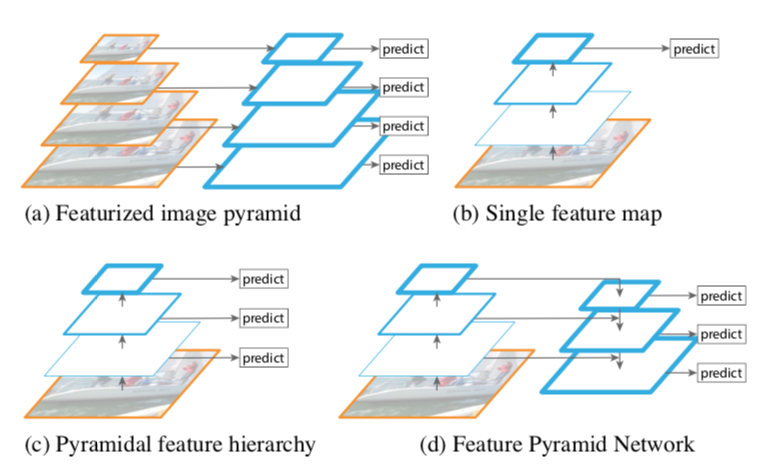

**FPN (Feature Pyramid Network) 개념**

- FPN은 특성을 **피라미드처럼 쌓아서 사용하는 방식**임.
- CNN 백본 네트워크에서는 다양한 레이어의 결과값을 **feature map** 으로 활용 가능.
- 컨볼루션 연산은 커널을 통해 일정 영역을 보고 정보를 요약하기 때문에,
  - **입력 이미지와 먼 뒷쪽 레이어의 특성 맵**: 하나의 "cell"이 넓은 이미지 영역 정보 포함
  - **입력 이미지와 가까운 앞쪽 레이어의 특성 맵**: 좁은 범위 정보 포함
- 이를 **receptive field**라고 함. 레이어가 깊어질수록 pooling을 거쳐 넓은 범위의 receptive field를 가짐.

**FPN의 핵심 아이디어**

- 백본의 여러 레이어를 **한꺼번에 활용**하겠다는 것에 의의
- SSD: 각 레이어 특성 맵에서 다양한 크기 결과를 얻음
- RetinaNet: **receptive field가 넓은 뒷쪽 특성 맵을 upsampling**하여 앞단 특성 맵과 합쳐서 사용
- 즉, 레이어 깊이에 따라 **넓게 보는 것과 좁게 보는 것**을 동시에 활용

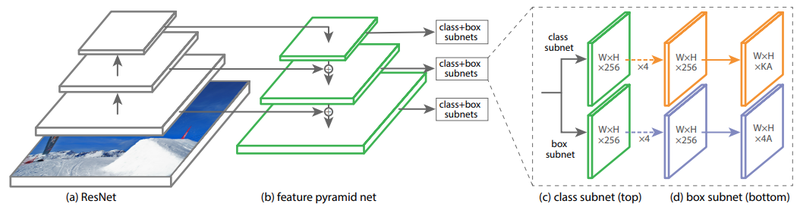

**RetinaNet에서의 FPN 활용**

- 위 그림은 RetinaNet 논문에서 **FPN 구조 적용**을 설명한 그림임.
- RetinaNet에서는 FPN을 통해 $P_3$ 부터 $P_7$ 까지의 **pyramid level**을 생성하여 사용
- 각 pyramid level은 **256개의 채널**로 구성
- 이를 기반으로 **Classification Subnet**과 **Box Regression Subnet** 2개의 Subnet 구성

**Subnet 채널 구성**

- Anchor 갯수를 $A$라고 하면:
  - **Classification Subnet**: $K$개 class에 대해 $K \cdot A$ 채널 사용
  - **Box Regression Subnet**: $4 \cdot A$ 채널 사용


# 4. 데이터 준비

## 4-1. 데이터 파이프 라인


In [100]:
def swap_xy(boxes):
    return torch.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], dim=-1)


In [101]:
def random_flip_horizontal(image, boxes):
    if torch.rand(1).item() > 0.5:
        image = TF.hflip(image)
        boxes = torch.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], dim=-1
        )

    return image, boxes

In [102]:
def resize_and_pad_image(image, training=True):
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0

    image_shape = torch.tensor(image.shape[-2:], dtype=torch.float32)
    if training:
        min_side = torch.empty(1).uniform_(min_side_range[0], min_side_range[1]).item()
    ratio = min_side / torch.min(image_shape)
    if ratio * torch.max(image_shape) > max_side:
        ratio = max_side / torch.max(image_shape)
    image_shape = ratio * image_shape
    new_size = tuple(image_shape.round().int().tolist())

    # Use torchvision functional for resize
    image = TF.resize(image, new_size)

    padded_image_shape = torch.ceil(image_shape / stride) * stride
    padded_image_shape = padded_image_shape.int().tolist()
    pad_h = padded_image_shape[0] - new_size[0]
    pad_w = padded_image_shape[1] - new_size[1]

    # Use nn.functional for padding tensor: (left, right, top, bottom)
    image = F.pad(image, (0, pad_w, 0, pad_h))
    return image, torch.tensor(new_size), ratio

In [103]:
def convert_to_xywh(boxes):
    return torch.cat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0,
         boxes[..., 2:] - boxes[..., :2]],
        dim=-1
    )

In [104]:
def preprocess_data(image, boxes, class_ids, training=True):
    # image: Tensor (C, H, W) or PIL
    # boxes: Tensor (N, 4) Normalized [xmin, ymin, xmax, ymax]
    # class_ids: Tensor (N)

    # Random flip (Only for training)
    if training:
        image, boxes = random_flip_horizontal(image, boxes)

    # Resize and pad (Scale jitter only for training)
    image, image_shape, _ = resize_and_pad_image(image, training=training)

    # Scale boxes to new image size (pixels)
    boxes = torch.stack(
        [
            boxes[:, 0] * image_shape[1],
            boxes[:, 1] * image_shape[0],
            boxes[:, 2] * image_shape[1],
            boxes[:, 3] * image_shape[0],
        ],
        dim=-1
    )

    # Convert to center format (cx, cy, w, h)
    boxes = convert_to_xywh(boxes)

    return image, boxes, class_ids

## 4-2. Encoding

In [105]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = torch.sqrt(torch.tensor(area, dtype=torch.float32) / torch.tensor(ratio, dtype=torch.float32))
                anchor_width = torch.tensor(area, dtype=torch.float32) / anchor_height
                dims = torch.stack([anchor_width, anchor_height], dim=-1).unsqueeze(0).unsqueeze(0)
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(torch.stack(anchor_dims, dim=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = torch.arange(feature_width, dtype=torch.float32) + 0.5
        ry = torch.arange(feature_height, dtype=torch.float32) + 0.5

        # Fix: meshgrid(y, x, indexing='ij') gives (H, W) grids
        # We want centers to be (x, y)
        grid_y, grid_x = torch.meshgrid(ry, rx, indexing='ij')
        centers = torch.stack([grid_x, grid_y], dim=-1) * self._strides[level - 3]

        centers = centers.unsqueeze(-2)
        centers = centers.repeat(1, 1, self._num_anchors, 1)
        dims = self._anchor_dims[level - 3].repeat(feature_height, feature_width, 1, 1)
        anchors = torch.cat([centers, dims], dim=-1)
        return anchors.view(feature_height * feature_width * self._num_anchors, 4)

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                int(image_height / 2 ** i),
                int(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return torch.cat(anchors, dim=0)

In [106]:
def convert_to_corners(boxes):
    return torch.cat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        dim=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = torch.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = torch.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = torch.maximum(torch.tensor(0.0), rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = torch.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, torch.tensor(1e-8)
    )
    return torch.clamp(intersection_area / union_area, min=0.0, max=1.0)

In [107]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = torch.tensor([0.1, 0.1, 0.2, 0.2], dtype=torch.float32)

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou, _ = torch.max(iou_matrix, dim=1)
        matched_gt_idx = torch.argmax(iou_matrix, dim=1)
        positive_mask = max_iou >= match_iou
        negative_mask = max_iou < ignore_iou
        ignore_mask = ~(positive_mask | negative_mask)
        return (
            matched_gt_idx,
            positive_mask.float(),
            ignore_mask.float(),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = torch.cat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                torch.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            dim=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = cls_ids.float()
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = gt_boxes[matched_gt_idx]
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = cls_ids[matched_gt_idx]
        cls_target = torch.where(
            positive_mask != 1.0, -1.0, matched_gt_cls_ids
        )
        cls_target = torch.where(ignore_mask == 1.0, -2.0, cls_target)
        cls_target = cls_target.unsqueeze(-1)
        label = torch.cat([box_target, cls_target], dim=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        batch_size = batch_images.size(0)

        labels = []
        for i in range(batch_size):
            label = self._encode_sample(batch_images.size(), gt_boxes[i], cls_ids[i])
            labels.append(label)
        batch_images = (batch_images - 0.485) / 0.229
        batch_images = (batch_images - 0.456) / 0.224
        batch_images = (batch_images - 0.406) / 0.225

        return batch_images, torch.stack(labels, dim=0)

# 5. Model 작성
- Feature Pyramid

In [108]:
class FeaturePyramid(nn.Module):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__()
        self.backbone = backbone
        # Fix: Match ResNet50 output channels (512, 1024, 2048)
        self.conv_c3_1x1 = nn.Conv2d(512, 256, 1, 1, padding=0)
        self.conv_c4_1x1 = nn.Conv2d(1024, 256, 1, 1, padding=0)
        self.conv_c5_1x1 = nn.Conv2d(2048, 256, 1, 1, padding=0)

        self.conv_c3_3x3 = nn.Conv2d(256, 256, 3, 1, padding=1)
        self.conv_c4_3x3 = nn.Conv2d(256, 256, 3, 1, padding=1)
        self.conv_c5_3x3 = nn.Conv2d(256, 256, 3, 1, padding=1)

        # Fix: C5 output has 2048 channels, so input channels must be 2048
        self.conv_c6_3x3 = nn.Conv2d(2048, 256, 3, 2, padding=1)

        self.conv_c7_3x3 = nn.Conv2d(256, 256, 3, 2, padding=1)
        self.upsample_2x = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, images):
        c3_output, c4_output, c5_output = self.backbone(images)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)

        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)

        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)

        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(F.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [109]:
def build_head(output_filters, bias_init):
    layers = []
    kernel_init = torch.nn.init.normal_(torch.empty(256, 256, 3, 3), mean=0.0, std=0.01)
    for _ in range(4):
        layers.append(nn.Conv2d(256, 256, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.Conv2d(256, output_filters, kernel_size=3, stride=1, padding=1))
    bias_init = 0.0 if bias_init == "zeros" else bias_init
    layers[-1].bias.data.fill_(bias_init)

    return nn.Sequential(*layers)

In [110]:
class ResNetBackbone(nn.Module):
    def __init__(self):
        super(ResNetBackbone, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.stem = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        x = self.stem(x)
        c2 = self.layer1(x)
        c3 = self.layer2(c2) # Pass c2 output to layer2
        c4 = self.layer3(c3) # Pass c3 output to layer3
        c5 = self.layer4(c4) # Pass c4 output to layer4
        return c3, c4, c5

def get_backbone():
    return ResNetBackbone()

In [111]:
class RetinaNet(nn.Module):
    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__()
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = -torch.log(torch.tensor((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def forward(self, image):
        features = self.fpn(image)
        N = image.size(0)
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(self.box_head(feature).view(N, -1, 4))
            cls_outputs.append(self.cls_head(feature).view(N, -1, self.num_classes))
        cls_outputs = torch.cat(cls_outputs, dim=1)
        box_outputs = torch.cat(box_outputs, dim=1)
        return torch.cat([box_outputs, cls_outputs], dim=-1)

In [112]:
class RetinaNetBoxLoss(nn.Module):
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__()
        self._delta = delta

    def forward(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = torch.abs(difference)
        squared_difference = difference ** 2
        loss = torch.where(
            absolute_difference < self._delta,
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return torch.sum(loss, dim=-1)

class RetinaNetClassificationLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__()
        self._alpha = alpha
        self._gamma = gamma

    def forward(self, y_true, y_pred):
        cross_entropy = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        probs = torch.sigmoid(y_pred)
        alpha = torch.where(y_true == 1.0, self._alpha, 1.0 - self._alpha)
        pt = torch.where(y_true == 1.0, probs, 1 - probs)
        loss = alpha * torch.pow(1.0 - pt, self._gamma) * cross_entropy
        return torch.sum(loss, dim=-1)

class RetinaNetLoss(nn.Module):
    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__()
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def forward(self, y_true, y_pred):
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]

        # Fix: Handle negative values (-1, -2) in labels before one_hot
        targets = y_true[:, :, 4].long()
        valid_mask = (targets >= 0)
        safe_targets = targets * valid_mask # Map -1, -2 to 0 temporarily

        cls_labels = F.one_hot(safe_targets, num_classes=self._num_classes).float()
        # Zero out the vectors for invalid anchors
        cls_labels = cls_labels * valid_mask.unsqueeze(-1).float()

        cls_predictions = y_pred[:, :, 4:]
        positive_mask = (y_true[:, :, 4] > -1.0).float()
        ignore_mask = (y_true[:, :, 4] == -2.0).float()

        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)

        clf_loss = torch.where(ignore_mask == 1.0, torch.zeros_like(clf_loss), clf_loss)
        box_loss = torch.where(positive_mask == 1.0, box_loss, torch.zeros_like(box_loss))

        normalizer = torch.sum(positive_mask, dim=-1)
        # Avoid division by zero
        normalizer = torch.clamp(normalizer, min=1.0)

        clf_loss = torch.div(torch.sum(clf_loss, dim=-1), normalizer)
        box_loss = torch.div(torch.sum(box_loss, dim=-1), normalizer)

        loss = clf_loss + box_loss
        return loss

# 6. Model 학습

In [136]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [137]:
# Adam 설정 (Object Detection에 적합한 학습률로 조정)
# Adam은 보통 SGD보다 낮은 학습률(1e-4 등)에서 잘 동작합니다.
learning_rates = [1e-5, 1e-4, 1e-5, 1e-6]

# KITTI 데이터셋 크기와 배치 사이즈(2) 고려: 1 Epoch 약 3000 step 예상
# Warmup (500) -> Main Training (~2 Epoch) -> Decay
learning_rate_boundaries = [500, 6000, 8000]

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates[0], weight_decay=1e-4)

def lr_lambda(step):
    # scheduler.step()이 배치마다 호출되므로 step은 iteration을 의미함
    for i, boundary in enumerate(learning_rate_boundaries):
        if step < boundary:
            return learning_rates[i] / learning_rates[0]
    return learning_rates[-1] / learning_rates[0]

scheduler = LambdaLR(optimizer, lr_lambda)

In [138]:
import glob
import os
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

# 데이터 경로 수정
train_data_dir = os.path.join(save_dir, 'training', 'training')

class KITTIDataset(Dataset):
    def __init__(self, root_dir, split='train', label_encoder=None, transform=True):
        self.img_dir = os.path.join(root_dir, "image_2")
        self.label_dir = os.path.join(root_dir, "label_2")
        self.split = split # Split 정보 저장

        all_files = sorted([os.path.basename(f) for f in glob.glob(os.path.join(self.img_dir, '*.png'))])

        split_idx = int(len(all_files) * 0.8)
        if split == 'train':
            self.filenames = all_files[:split_idx]
        else:
            self.filenames = all_files[split_idx:]

        self.label_encoder = label_encoder
        self.transform = transform

        self.class_dict = {
            'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3,
            'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7
        }

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.img_dir, filename)
        label_path = os.path.join(self.label_dir, filename.replace('.png', '.txt'))

        image = Image.open(img_path).convert("RGB")
        w, h = image.size
        # Use TF (torchvision.transforms.functional) for to_tensor
        image = TF.to_tensor(image)

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    cls_name = parts[0]
                    if cls_name in self.class_dict:
                        l, t, r, b = map(float, parts[4:8])
                        boxes.append([l/w, t/h, r/w, b/h])
                        labels.append(self.class_dict[cls_name])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int32)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int32)

        if self.transform:
            # Train set일 때만 Augmentation 적용
            is_training = (self.split == 'train')
            image, boxes, labels = preprocess_data(image, boxes, labels, training=is_training)

        if self.label_encoder:
            encoded_label = self.label_encoder._encode_sample(image.shape, boxes, labels)
        else:
            encoded_label = (boxes, labels)

        # Image Normalization (Corrected)
        # 채널별로 올바르게 브로드캐스팅 되도록 view 사용
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std

        return image, encoded_label

def collate_fn(batch):
    images, labels = zip(*batch)
    max_width = max(img.shape[1] for img in images)
    max_height = max(img.shape[0] for img in images)
    pad_value = 0.0

    padded_images = []
    for img in images:
        pad_h = max_height - img.shape[0]
        pad_w = max_width - img.shape[1]
        padded_img = F.pad(img, (0, pad_w, 0, pad_h), value=pad_value)
        padded_images.append(padded_img)

    images = torch.stack(padded_images)
    labels = torch.stack(labels)

    return images, labels

label_encoder = LabelEncoder()

train_dataset = KITTIDataset(train_data_dir, split='train', label_encoder=label_encoder)
val_dataset = KITTIDataset(train_data_dir, split='val', label_encoder=label_encoder)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn, num_workers=4
)
val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False, drop_last=True, collate_fn=collate_fn, num_workers=4
)

In [141]:
import time

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

epochs = 20
log_interval = 100

print("Start Training...")
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    start_time = time.time()

    for batch_idx, (images, encoded_labels) in enumerate(train_loader):
        images = images.to(device)
        encoded_labels = encoded_labels.to(device)

        # Gradient 초기화
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Loss 계산
        loss = loss_fn(encoded_labels, outputs)

        # Fix: Loss가 (Batch_Size,) 형태이므로, scalar로 만들어주기 위해 평균을 구함
        loss = loss.mean()

        # Backward pass
        loss.backward()

        # Optimizer & Scheduler step
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    avg_loss = total_loss / len(train_loader)
    print('Epoch: {} \tAverage Loss: {:.6f} \tTime: {:.2f}s'.format(
        epoch, avg_loss, time.time() - start_time))

    # Checkpoint 저장
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, os.path.join(save_dir, f'checkpoint_epoch_{epoch}.pth'))

Start Training...
Train Epoch: 1 [0/5984 (0%)]	Loss: 3.915417
Train Epoch: 1 [200/5984 (3%)]	Loss: 3.568967
Train Epoch: 1 [400/5984 (7%)]	Loss: 3.525835
Train Epoch: 1 [600/5984 (10%)]	Loss: 3.562862
Train Epoch: 1 [800/5984 (13%)]	Loss: 3.600832
Train Epoch: 1 [1000/5984 (17%)]	Loss: 3.668070
Train Epoch: 1 [1200/5984 (20%)]	Loss: 3.643034
Train Epoch: 1 [1400/5984 (23%)]	Loss: 3.921275
Train Epoch: 1 [1600/5984 (27%)]	Loss: 3.792980
Train Epoch: 1 [1800/5984 (30%)]	Loss: 3.609650
Train Epoch: 1 [2000/5984 (33%)]	Loss: 3.785254
Train Epoch: 1 [2200/5984 (37%)]	Loss: 3.670663
Train Epoch: 1 [2400/5984 (40%)]	Loss: 3.680815
Train Epoch: 1 [2600/5984 (43%)]	Loss: 3.519877
Train Epoch: 1 [2800/5984 (47%)]	Loss: 3.417013
Train Epoch: 1 [3000/5984 (50%)]	Loss: 3.599387
Train Epoch: 1 [3200/5984 (53%)]	Loss: 3.737864
Train Epoch: 1 [3400/5984 (57%)]	Loss: 3.443889
Train Epoch: 1 [3600/5984 (60%)]	Loss: 3.803358
Train Epoch: 1 [3800/5984 (64%)]	Loss: 3.576479
Train Epoch: 1 [4000/5984 (67%)]

In [140]:
# import torch
# import gc

# # 불필요한 변수 삭제
# del images, encoded_labels, outputs, loss
# gc.collect()

# # GPU 캐시 비우기
# torch.cuda.empty_cache()

# 7. 결과 확인하기

In [142]:
# 모델 초기화 (학습때와 동일한 구조)
# resnet50_backbone 변수가 메모리에 없으면 get_backbone()으로 다시 생성 필요
if 'resnet50_backbone' not in locals():
    resnet50_backbone = get_backbone()

model = RetinaNet(num_classes, resnet50_backbone)
model = model.to(device)

# Optimizer (필요하다면 로드, 여기서는 로드만 테스트)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates[0], weight_decay=1e-4)

# 가장 최근 체크포인트 찾기
checkpoints = sorted(glob.glob(os.path.join(save_dir, 'checkpoint_epoch_*.pth')), key=os.path.getmtime)

if len(checkpoints) > 0:
    checkpoint_path = checkpoints[-1] # 가장 마지막 파일 선택
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded successfully from {checkpoint_path} (Epoch {epoch}, Loss {loss:.4f})")
else:
    print(f"No checkpoint found in {save_dir}, using initialized model.")

model.eval()
print('Model ready for inference')

Checkpoint loaded successfully from /content/drive/MyDrive/Data/GoingDeeperQ5/KITTY/checkpoint_epoch_20.pth (Epoch 20, Loss 3.2181)
Model ready for inference


In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import nms  # PyTorch에서 NMS 기능 제공

class DecodePredictions(nn.Module):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections
        self._anchor_box = AnchorBox()
        self._box_variance = torch.tensor(box_variance, dtype=torch.float32)

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        # Fix 1: Move box_variance to the correct device
        boxes = box_predictions * self._box_variance.to(box_predictions.device)
        boxes = torch.cat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                torch.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            dim=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def forward(self, images, predictions):
        image_shape = images.shape
        anchor_boxes = self._anchor_box.get_anchors(image_shape[2], image_shape[3])

        box_predictions = predictions[:, :, :4]

        # Fix 2: Move anchor_boxes to the correct device
        anchor_boxes = anchor_boxes.to(box_predictions.device)

        cls_predictions = torch.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        selected_boxes = []
        selected_scores = []
        selected_classes = []

        for i in range(boxes.shape[0]):
            for class_id in range(self.num_classes):
                class_scores = cls_predictions[i, :, class_id]
                mask = class_scores > self.confidence_threshold
                if mask.sum() == 0:
                    continue
                class_boxes = boxes[i, mask]
                class_scores = class_scores[mask]
                keep = nms(class_boxes, class_scores, self.nms_iou_threshold)
                selected_boxes.append(class_boxes[keep])
                selected_scores.append(class_scores[keep])
                selected_classes.append(torch.full_like(class_scores[keep], class_id, dtype=torch.int64))

        num_detections = len(selected_boxes)
        selected_boxes = torch.cat(selected_boxes, dim=0) if selected_boxes else torch.empty(0, 4)
        selected_scores = torch.cat(selected_scores, dim=0) if selected_scores else torch.empty(0)
        selected_classes = torch.cat(selected_classes, dim=0) if selected_classes else torch.empty(0, dtype=torch.int64)
        num_detections = min(self.max_detections, num_detections)
        selected_boxes = selected_boxes[:num_detections]
        selected_scores = selected_scores[:num_detections]
        selected_classes = selected_classes[:num_detections]

        return selected_boxes, selected_scores, selected_classes

In [144]:
def run_inference(model, image, threshold=0.5):
    model.eval()
    with torch.no_grad():
        # image: (1, C, H, W)
        image = image.to(device)
        outputs = model(image) # (1, num_anchors, 4 + num_classes)

    decoder = DecodePredictions(confidence_threshold=threshold)
    # DecodePredictions.forward takes (images, predictions)
    boxes, scores, classes = decoder(image, outputs)
    return boxes.cpu(), scores.cpu(), classes.cpu()

In [145]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [146]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)

    return image, ratio


Detected 0 objects


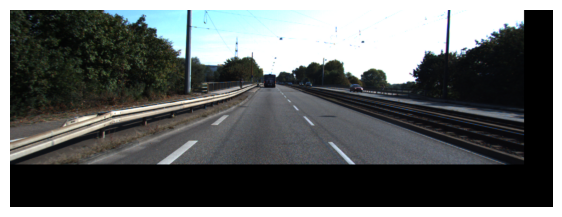

<Axes: >

In [150]:
import matplotlib.pyplot as plt
import numpy as np

# 테스트 이미지 가져오기 (Validation set의 첫번째 이미지 사용)
image, encoded_label = val_dataset[11] # (3, H, W)

# Inference를 위해 배치 차원 추가
input_image = image.unsqueeze(0) # (1, 3, H, W)

# 추론 실행
boxes, scores, classes = run_inference(model, input_image, threshold=0.3)

# 시각화를 위한 이미지 역정규화 (Denormalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
vis_image = image * std + mean
vis_image = torch.clamp(vis_image, 0, 1)
vis_image = vis_image.permute(1, 2, 0).numpy() # (H, W, 3)
vis_image = (vis_image * 255).astype(np.uint8)

# Class 이름 매핑
class_names_map = list(train_dataset.class_dict.keys())
pred_class_names = [class_names_map[i] for i in classes]

print(f"Detected {len(boxes)} objects")

# 시각화 함수 호출
visualize_detections(
    vis_image,
    boxes,
    pred_class_names,
    scores,
)